In [1]:

%matplotlib inline
import sys, pathlib
import torch
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

ROOT = pathlib.Path.cwd()
if (ROOT / 'config_dataset.py').exists():
    sys.path.append(str(ROOT))
elif (ROOT.parent / 'config_dataset.py').exists():
    ROOT = ROOT.parent
    sys.path.append(str(ROOT))

from config_dataset import NUM_ITEMS
from src.data.load_data import load_training_data
from src.data.preprocessing import create_dt_dataset, validate_preprocessing
from src.data.dataset import RecommendationDataset
from src.models.decision_transformer import DecisionTransformer
from src.training.trainer import train_decision_transformer

print(f"NUM_ITEMS: {NUM_ITEMS}")
print(f"GPU disponible: {torch.cuda.is_available()}")


NUM_ITEMS: 752
GPU disponible: False


## Cargar datos procesados

In [2]:

import pickle
processed_path = ROOT / 'data/processed/trajectories_train.pkl'

if processed_path.exists():
    with processed_path.open('rb') as f:
        trajectories = pickle.load(f)
    print(f"Cargadas trayectorias desde {processed_path} -> {len(trajectories)}")
else:
    df_train = load_training_data()
    trajectories = create_dt_dataset(df_train)
    validate_preprocessing(trajectories)
    processed_path.parent.mkdir(parents=True, exist_ok=True)
    with processed_path.open('wb') as f:
        pickle.dump(trajectories, f)
    print(f"Generadas y guardadas trayectorias -> {len(trajectorias)}")


Cargadas trayectorias desde /home/manu/Documentos/diplo/tp_decision_transformer/data/processed/trajectories_train.pkl -> 16000


## Crear DataLoaders

In [3]:

context_length = 20
batch_size = 64
val_frac = 0.1

full_dataset = RecommendationDataset(trajectories, context_length=context_length)
val_size = int(len(full_dataset) * val_frac)
train_size = len(full_dataset) - val_size
train_ds, val_ds = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

print(f"Train size: {train_size}, Val size: {val_size}")
print(f"Batch size: {batch_size}")


Train size: 14400, Val size: 1600
Batch size: 64


## Sanity check (opcional)

In [4]:

df_subset = load_training_data().head(200)
traj_subset = create_dt_dataset(df_subset)
validate_preprocessing(traj_subset)

sanity_ds = RecommendationDataset(traj_subset, context_length= context_length)
san_loader = DataLoader(sanity_ds, batch_size=64, shuffle=True)

model_sanity = DecisionTransformer(num_items=NUM_ITEMS, num_groups=8, hidden_dim=128, n_layers=3, n_heads=4, context_length=context_length)
opt_sanity = torch.optim.Adam(model_sanity.parameters(), lr=1e-3)

model_sanity = train_decision_transformer(model_sanity, san_loader, opt_sanity, torch.device('cuda' if torch.cuda.is_available() else 'cpu'), num_epochs=3)


Epoch 1/3, Loss: 6.6410
Epoch 2/3, Loss: 6.6330
Epoch 3/3, Loss: 6.6262


## Entrenamiento principal

In [5]:

hidden_dim = 256
n_layers = 4
n_heads = 8
learning_rate = 2e-4
num_epochs = 50

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = DecisionTransformer(
    num_items=NUM_ITEMS,
    num_groups=8,
    hidden_dim=hidden_dim,
    n_layers=n_layers,
    n_heads=n_heads,
    context_length=context_length,
)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [6]:

model, train_history = train_decision_transformer(
    model,
    train_loader,
    optimizer,
    device,
    num_epochs=num_epochs,
    return_history=True,
)


Epoch 1/50, Loss: 6.6245
Epoch 2/50, Loss: 6.6234
Epoch 3/50, Loss: 6.6232
Epoch 4/50, Loss: 6.6232
Epoch 5/50, Loss: 6.6231
Epoch 6/50, Loss: 6.6230
Epoch 7/50, Loss: 6.6229
Epoch 8/50, Loss: 6.6230
Epoch 9/50, Loss: 6.6228
Epoch 10/50, Loss: 6.6228
Epoch 11/50, Loss: 6.6228
Epoch 12/50, Loss: 6.6227
Epoch 13/50, Loss: 6.6227
Epoch 14/50, Loss: 6.6227
Epoch 15/50, Loss: 6.6226
Epoch 16/50, Loss: 6.6225
Epoch 17/50, Loss: 6.6226
Epoch 18/50, Loss: 6.6225
Epoch 19/50, Loss: 6.6226
Epoch 20/50, Loss: 6.6226
Epoch 21/50, Loss: 6.6225
Epoch 22/50, Loss: 6.6225
Epoch 23/50, Loss: 6.6225
Epoch 24/50, Loss: 6.6225
Epoch 25/50, Loss: 6.6225
Epoch 26/50, Loss: 6.6225
Epoch 27/50, Loss: 6.6225
Epoch 28/50, Loss: 6.6224
Epoch 29/50, Loss: 6.6225
Epoch 30/50, Loss: 6.6225
Epoch 31/50, Loss: 6.6224
Epoch 32/50, Loss: 6.6225
Epoch 33/50, Loss: 6.6225
Epoch 34/50, Loss: 6.6225
Epoch 35/50, Loss: 6.6224
Epoch 36/50, Loss: 6.6224
Epoch 37/50, Loss: 6.6224
Epoch 38/50, Loss: 6.6224
Epoch 39/50, Loss: 6.

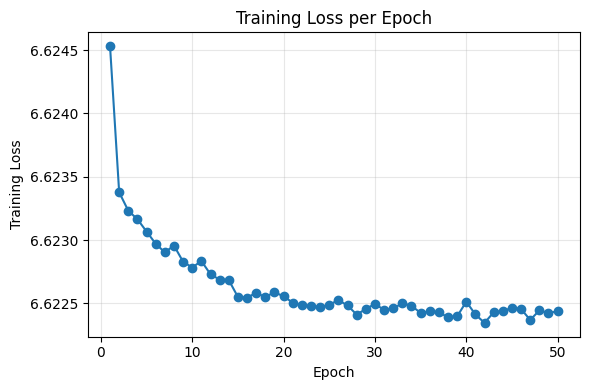

Figura guardada en /home/manu/Documentos/diplo/tp_decision_transformer/results/figures/training_loss.png
Log guardado en /home/manu/Documentos/diplo/tp_decision_transformer/results/logs/training_loss.txt


In [8]:

fig, ax = plt.subplots(figsize=(6,4))
ax.plot(range(1, len(train_history)+1), train_history, marker='o')
ax.set_xlabel('Epoch')
ax.set_ylabel('Training Loss')
ax.set_title('Training Loss per Epoch')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

fig_path = ROOT / 'results/figures/training_loss.png'
fig_path.parent.mkdir(parents=True, exist_ok=True)
fig.savefig(fig_path, dpi=300)
print(f'Figura guardada en {fig_path}')

log_path = ROOT / 'results/logs/training_loss.txt'
log_path.parent.mkdir(parents=True, exist_ok=True)
with log_path.open('w') as f:
    for epoch, loss in enumerate(train_history, start=1):
        f.write(f'Epoch {epoch}: {loss:.6f}\n')
print(f'Log guardado en {log_path}')


## Guardar checkpoint

In [9]:

ckpt_path = ROOT / 'results/checkpoints/dt_checkpoint.pt'
ckpt_path.parent.mkdir(parents=True, exist_ok=True)
torch.save(model.state_dict(), ckpt_path)
print(f"Checkpoint guardado en {ckpt_path}")


Checkpoint guardado en /home/manu/Documentos/diplo/tp_decision_transformer/results/checkpoints/dt_checkpoint.pt
